In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 

import sys
sys.path.append('../')
import utils
import plotting

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from math import radians, cos, sin, asin, sqrt


In [2]:
all_paths = ['nei_NA','normal_NA','nonuc_NA','nonuc_coal_NA','egrid_NA','epa_NA']

In [3]:
ds_import = {}
for path in all_paths:
    ds_import[path] = xr.open_dataset(f'/net/fs11/d0/emfreese/GCrundirs/nuclearproj/{path}/merged_data/merged_O3_JJA_hourly.nc4')
    
dsO3_hrly = xr.concat([ds_import[path] for path in all_paths], 
                      pd.Index(all_paths, name='model_name'))


In [4]:


# In[2]:


poll_ds = xr.open_dataset('final_data/ds_PM_O3_daily.nc4')

print('imported')
# In[3]:


counties = geopandas.read_file('data/cb_2018_us_county_500k.shx')
counties = counties.rename(columns = {'NAME':'CountyName'})

print('imported')

# In[4]:


states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states = states.rename(columns = {'NAME':'StateName'})


# states_counties = states.merge(counties)

# In[5]:



imported
imported


In [5]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')


In [6]:
df = pd.read_csv('final_data/df_pm_o3_county_nuclear_geo_avg.csv')

In [7]:
df['geometry'] = geopandas.GeoSeries.from_wkt(df['geometry_county'])
geo_df = geopandas.GeoDataFrame(df, geometry='geometry')

<AxesSubplot:>

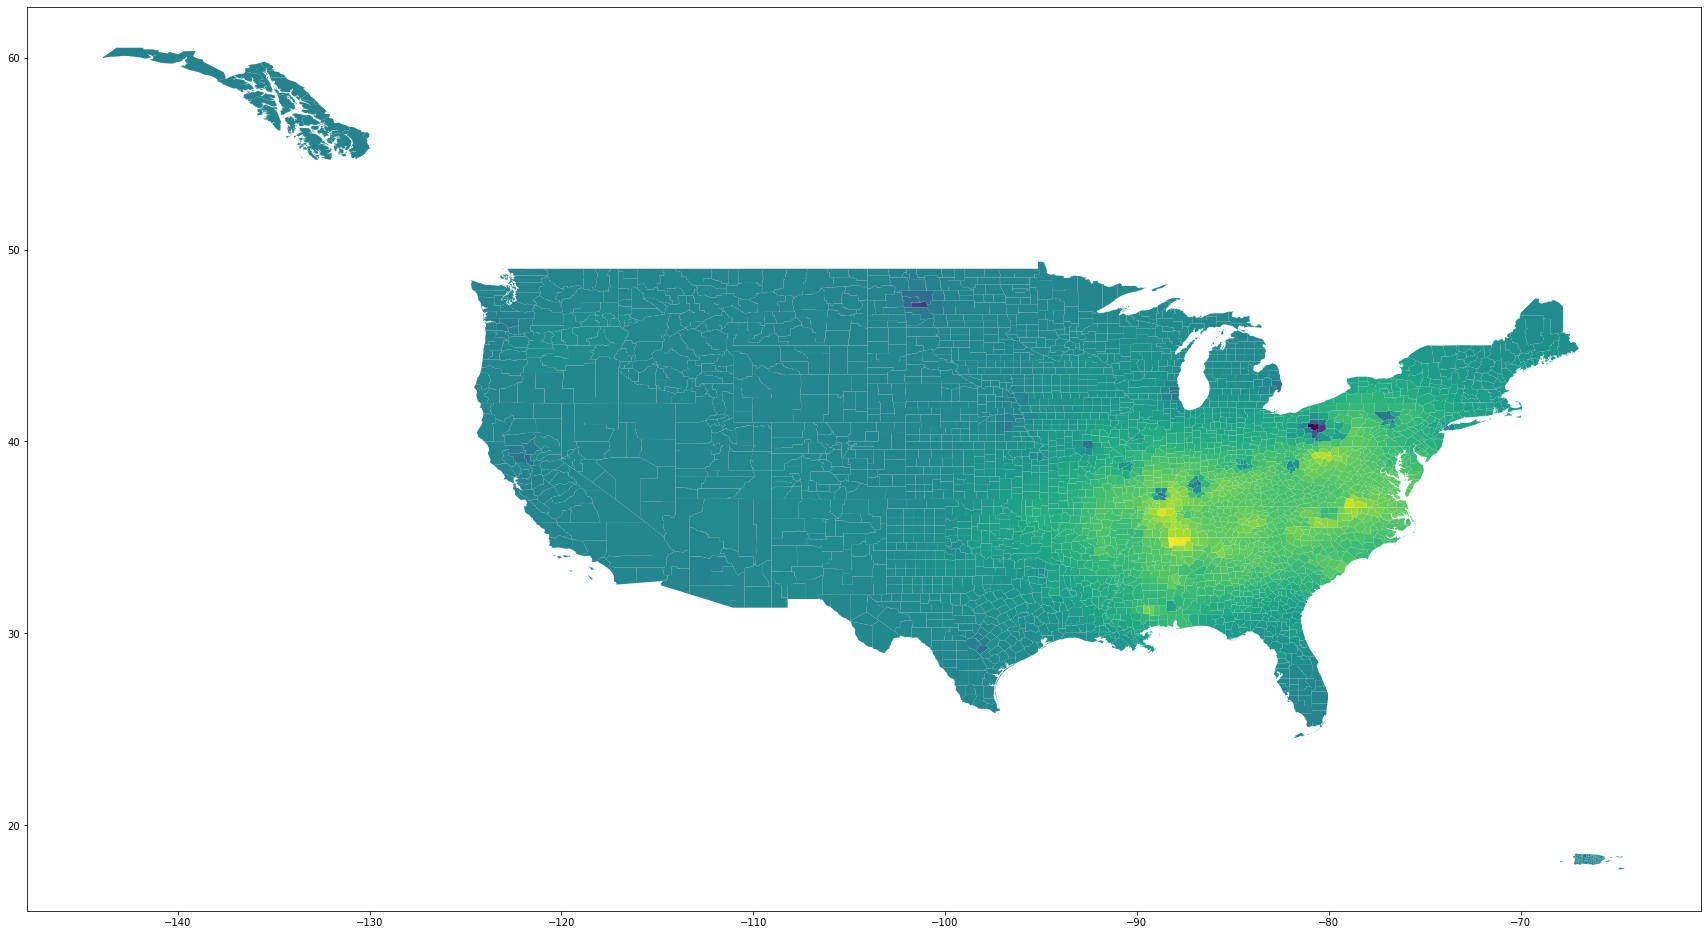

In [8]:
geo_df.plot(figsize = (30,30), column = 'O3')

In [8]:

counties = counties.reset_index()


# In[6]:


counties['index'] = counties['index'].astype('int32')


# In[7]:


counties['STATEFP'] = counties['STATEFP'].astype('int32')



In [9]:

# In[8]:


weightmap = xa.pixel_overlaps(poll_ds,counties)

print('weightmap complete')

# In[9]:





creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
weightmap complete


In [10]:
aggregated= xa.aggregate(poll_ds,weightmap)
print('aggregate complete')


# In[ ]:


aggregating O3...
aggregating PM25...
all variables aggregated to polygons!
aggregate complete


In [11]:
aggregated.to_netcdf('aggregated_counties.nc')
print('aggregate saved')

aggregated_counties.nc saved!
aggregate saved


In [12]:
ds_reduced_o3 = dsO3_hrly['SpeciesConc_O3'].sel(time = dsO3_hrly.time.dt.hour.isin([np.arange(10,18)])).isel(lev = 0)

In [13]:
aggregated_hourly_O3 = xa.aggregate(ds_reduced_o3, weightmap)



aggregating SpeciesConc_O3...
all variables aggregated to polygons!


In [14]:
ds_out = aggregated.to_dataset()

In [15]:
ds_hrly = aggregated_hourly_O3.to_dataset()

## Import our locations of coal plants

In [16]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)
df_normal.loc[df_normal['CountyName'] == 'La Salle','CountyName'] = 'LaSalle'
df_normal.loc[df_normal['CountyName'] == 'WestChester','CountyName'] = 'Westchester'
df_normal.loc[df_normal['CountyName'] == 'Apache', 'StateName'] = 'Arizona'
df_normal.loc[df_normal['CountyName'] == 'Dona Ana','CountyName'] = 'Doña Ana'
df_normal.loc[df_normal['CountyName'] == 'St Charles','CountyName'] = 'St. Charles'
df_normal.loc[df_normal['CountyName'] == 'St Clair','CountyName'] = 'St. Clair'

df_normal['CountyName'] = df_normal['CountyName'].str.lower()
df_normal['StateName'] = df_normal['StateName'].str.lower()


In [17]:
df_coal = df_normal[df_normal['FuelType'] == 'Coal'][['LAT','LON']].groupby(['LAT','LON']).mean().reset_index()

In [18]:
gdf_coal = geopandas.GeoDataFrame(
    df_coal, geometry=geopandas.points_from_xy(df_coal.LON, df_coal.LAT))
gdf_coal['geometry'].crs = counties['geometry'].crs

In [43]:
gdf_coal = gdf_coal.to_crs(counties.geometry.crs)

## Import our locations of the nuclear plants

In [19]:
df_nuclear = df_normal[df_normal['FuelType'] == 'Nuclear'][['LAT','LON']].groupby(['LAT','LON']).mean().reset_index()

In [20]:
gdf_nuclear = geopandas.GeoDataFrame(
    df_nuclear, geometry=geopandas.points_from_xy(df_nuclear.LON, df_nuclear.LAT))
gdf_nuclear['geometry'].crs = counties['geometry'].crs

## Calculate those counties with a distance < 50 miles from a power plant

In [21]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [22]:
counties['nuclear_adjacent'] = False
counties['coal_containing'] = False

In [60]:
counties.loc[counties['COUNTYNS'].isin(geopandas.sjoin(left_df=gdf_coal, right_df=counties, how='inner')['COUNTYNS']), 'coal_containing'] = True

In [64]:
for county in counties['geometry']:
    for nuc in gdf_nuclear['geometry']:
        poly = county
        point = nuc
        # The points are returned in the same order as the input geometries:
        p1, p2 = nearest_points(poly, point)
        #print(haversine(p1.x, p1.y, p2.x, p2.y))
        if haversine(p1.x, p1.y, p2.x, p2.y) <= 80.4672:
            counties.loc[counties['geometry'] == county,'nuclear_adjacent'] = True
    
        

In [65]:
poll_ds = ds_out.swap_dims({'pix_idx':'COUNTYNS'})[['PM25']]
ds_hrly = ds_hrly.swap_dims({'pix_idx':'COUNTYNS'})[['SpeciesConc_O3']]

poll_df = (utils.season_mean(poll_ds).sel(model_name = 'nonuc_NA')-utils.season_mean(poll_ds).sel(model_name = 'normal_NA')).drop('pix_idx').to_dataframe()

In [66]:
poll_df = (poll_ds.mean(dim = 'time').sel(model_name = 'nonuc_NA') - 
           poll_ds.mean(dim = 'time').sel(model_name = 'normal_NA')).drop('pix_idx').to_dataframe()

In [67]:
hrly_df = (ds_hrly.mean(dim = 'time').sel(model_name = 'nonuc_NA') - 
           ds_hrly.mean(dim = 'time').sel(model_name = 'normal_NA')).drop('pix_idx').to_dataframe()

In [68]:
poll_df = poll_df.reset_index()

In [69]:
hrly_df = hrly_df.reset_index()

In [70]:
hrly_df = hrly_df.rename(columns = {'SpeciesConc_O3':'O3'})

In [71]:
poll_nocoal_df = (poll_ds.mean(dim = 'time').sel(model_name = 'nonuc_coal_NA') - 
           poll_ds.mean(dim = 'time').sel(model_name = 'normal_NA')).drop('pix_idx').to_dataframe()

hrly_nocoal_df = (ds_hrly.mean(dim = 'time').sel(model_name = 'nonuc_coal_NA') - 
           ds_hrly.mean(dim = 'time').sel(model_name = 'normal_NA')).drop('pix_idx').to_dataframe()

poll_nocoal_df = poll_nocoal_df.reset_index()
hrly_nocoal_df = hrly_nocoal_df.reset_index()

hrly_nocoal_df = hrly_nocoal_df.rename(columns = {'SpeciesConc_O3':'O3'})

## Include State and County Info

In [72]:
states['STATEFP'] = states['STATEFP'].astype('int32')

In [73]:
states_counties = states.merge(counties, on = 'STATEFP', suffixes=('_state', '_county'))[['index','CountyName','StateName','nuclear_adjacent','coal_containing','COUNTYNS','geometry_county']]

In [74]:
states_counties['County_State'] = states_counties[['CountyName','StateName']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)


In [75]:
full_df = pd.merge(states_counties, poll_df, on = ['COUNTYNS',])

In [76]:
full_df = pd.merge(full_df, hrly_df, on = 'COUNTYNS')

In [77]:
full_df.to_csv('./final_data/df_pm_o3_county_nuclear_geo_avg.csv')

In [78]:
full_nocoal_df = pd.merge(states_counties, poll_nocoal_df, on = ['COUNTYNS',])
full_nocoal_df = pd.merge(full_nocoal_df, hrly_nocoal_df, on = 'COUNTYNS')
full_nocoal_df.to_csv('./final_data/df_pm_o3_county_nuclear_geo_avg_nocoal.csv')